<h3>OVERVIEW</h3>

Updates 9/11/23: I fixed the bugs and added Google colab functionality. I switched the order of sections 1 and 2 so that the most relevant section is first and put data processing into a different Jupyter notebook "data-processing.ipynb" (because that one requires the original data files which are huge)

**Instructions:**
- Download `\cleaned-data-for-visualization\data-processed` from OneDrive and put the folder into the same path as this Jupyter notebook if running locally or upload to Google Drive if running on Google Colab
- To run on Google colab, set the `path` variable to the path of the `data-processed` folder in section 0
- Run Section 0. You can run Section 1 and Section 2 independently.

**Section 0:** Import modules and initialize variables

**Section 1:** Load, visualize, and compute stats for HbR over all participants / sessions
- **Section 1.1:** Load and visualize mean HbR for all participants / sessions
- **Section 1.2:** Compute stats

**Section 2:** Process/load and visualize data for a single participant / session
- **Section 2.1:** Load processed data
- **Section 2.2:** Compute mean and standard deviation across trials
- **Section 2.3:** Visualize data


<h3>SECTION 0</h3>

Import modules and initialize variables

In [39]:
# If running on Google Colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [40]:
import pandas as pd

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from datetime import datetime

from numpy.random import seed
from numpy.random import randn
from numpy.random import normal
from scipy import stats

# Create variables
# Path of the "data-processed" folder
path = "data-processed/"

# For colab only: update the file path of the data-processed folder, otherwise, comment the next line out
path = "/content/drive/MyDrive/BrAIn_Jam/data/data-processed/"

conditions = ['Control', 'Condition 1', 'Condition 2', 'Condition 3']
current_condition = -1

<h3>SECTION 1</h3> Load, visualize, and compute stats for HbR over all participants / sessions

**1.1 Load and visualize mean HbR for all participants / sessions**
- Load dataframes (in `dfs_all`) with FNIRs channels as columns, mean HbR/HbO over all channels and relative mean HbR/HbO over all channels (mean HbR/HbO normalized to 0 at time 0 for each trial) for each time step

- Create dataframes (in `hbrs_all`, `hbos_all`) with relative mean HbR/HbO for each trial as columns, and the mean and standard deviation of HbR/HbO over all trials at each time step

- Visualize mean HbR over time for C1, C2, and C3 with standard error bars (over all participants / sessions)

In [41]:
# Load processed data from CSV files

file_names = {"Sam 1": [f'{path}sam-1-' + cond for cond in ['c.csv','c1.csv','c2.csv','c3.csv']],\
"Sam 2": [f'{path}sam-2-' + cond for cond in ['c.csv','c1.csv','c2.csv','c3.csv']],\
"Niko 1": [f'{path}niko-1-' + cond for cond in ['c.csv','c1.csv','c2.csv','c3.csv']],\
"Niko 2": [f'{path}niko-2-' + cond for cond in ['c.csv','c1.csv','c2.csv','c3.csv']]}

dfs_all = {}
for key in file_names:
      data = []
      for file_name in file_names[key]:
            data.append(pd.read_csv(file_name))
      dfs_all[key] = data

In [42]:
# Calculate mean and stdev of HbR and HbO across all trials
hbr_c_all = pd.DataFrame()
hbr_c1_all = pd.DataFrame()
hbr_c2_all = pd.DataFrame()
hbr_c3_all = pd.DataFrame()

hbrs_all = [hbr_c_all, hbr_c1_all, hbr_c2_all, hbr_c3_all]

hbo_c_all = pd.DataFrame()
hbo_c1_all = pd.DataFrame()
hbo_c2_all = pd.DataFrame()
hbo_c3_all = pd.DataFrame()

hbos_all = [hbo_c_all, hbo_c1_all, hbo_c2_all, hbo_c3_all]

#drop final rows for each trial because there's noise
drop = 3

num_rows_arr = [1000, 1000, 1000, 1000]
for key in dfs_all:
    # print(i_condition)
    for i_condition, df_condition in enumerate(dfs_all[key]):
        for i, trial in df_condition.groupby("Trial"):
            if len(trial.index) < num_rows_arr[i_condition]:
                num_rows_arr[i_condition] = len(trial.index)

# print(num_rows_arr)

for key in dfs_all:
    # print(i_condition)
    for i_condition, df_condition in enumerate(dfs_all[key]):
        for i, trial in df_condition.groupby("Trial"):
            hbos_all[i_condition][f'{key} Trial {i}'] = trial['Relative HbO'].values[0:num_rows_arr[i_condition]-drop]
            hbrs_all[i_condition][f'{key} Trial {i}'] = trial['Relative HbR'].values[0:num_rows_arr[i_condition]-drop]


# Drop trials
hbr_c1_all.drop(['Sam 1 Trial 10','Sam 1 Trial 12'],axis=1,inplace=True)
hbr_c2_all.drop(['Sam 1 Trial 11'],axis=1,inplace=True)


# Calculate mean and stdev of HbR and HbO across all trials
for df_curr in hbrs_all:
    mean = df_curr.mean(axis=1)
    df_curr.insert(0, 'Mean', mean, True)

    stdev = df_curr.std(axis=1)
    df_curr.insert(1, 'Stdev', stdev, True)

for i, df_curr in enumerate(hbrs_all):
    time = dfs_all['Sam 1'][i].loc[0:len(df_curr.index),'Time']
    df_curr.insert(0, 'Time', time, True)


for df_curr in hbos_all:
    mean = df_curr.mean(axis=1)
    df_curr.insert(0, 'Mean', mean, True)

    stdev = df_curr.std(axis=1)
    df_curr.insert(1, 'Stdev', stdev, True)

for i, df_curr in enumerate(hbos_all):
    time = dfs_all['Sam 1'][i].loc[0:len(df_curr.index),'Time']
    df_curr.insert(0, 'Time', time, True)

Text(0.5, 1.0, 'Mean HbR Over Time')

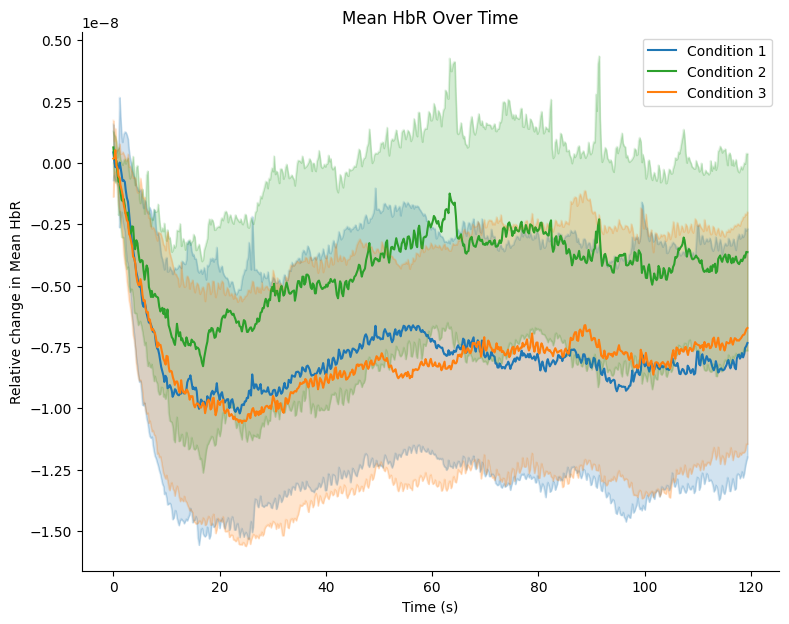

In [43]:
#Plot HbR

colors = ['blue','blue','green','orange']
# Draw plot with error band and extra formatting to match seaborn style
fig, ax = plt.subplots(figsize=(9,7))
for i, hbr in enumerate(hbrs_all):
    # Matplotlib plot with custom error band

    if i != 0:
        # Define variables to plot
        y_mean = hbr['Mean']
        x = hbr['Time']

        # Compute upper and lower bounds using chosen uncertainty measure: here
        # it is a fraction of the standard deviation of measurements at each
        # time point based on the unbiased sample variance
        y_std = hbr['Stdev']
        error = 0.5*y_std
        lower = y_mean - error
        upper = y_mean + error

        ax.plot(x, y_mean, color=f'tab:{colors[i]}', label = f'{conditions[i]}')
        ax.plot(x, lower, color=f'tab:{colors[i]}', alpha=0.1)
        ax.plot(x, upper, color=f'tab:{colors[i]}', alpha=0.1)
        ax.fill_between(x, lower, upper, color=f'tab:{colors[i]}', alpha=0.2)
        ax.set_xlabel('Time (s)')
        ax.set_ylabel('Relative change in Mean HbR')
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

plt.legend()
plt.title('Mean HbR Over Time')



**1.2 Compute stats**

Run t-test and compute T-statistic value and P-value for each set of conditions (over all participants / sessions)

In [ ]:
hbr_means = []
for hbr in hbrs_all:
    hbr_mean = hbr.mean(axis=0)
    hbr_means.append(list(hbr_mean[:-3]))

In [ ]:
for i, mean in enumerate(hbr_means):
    for j, mean in enumerate(hbr_means):
        if j > i:

            t_stat, p_value = stats.ttest_ind(hbr_means[i], hbr_means[j])
            print(f"{conditions[i]} /{conditions[j]}   T-statistic value: {t_stat}   P-value: {p_value}")

Control /Condition 1   T-statistic value: 0.20545318837838072   P-value: 0.8378143766136368
Control /Condition 2   T-statistic value: 0.08724183285152733   P-value: 0.930765048456081
Control /Condition 3   T-statistic value: 0.18075496490243056   P-value: 0.8570975604137077
Condition 1 /Condition 2   T-statistic value: -0.13186480670209352   P-value: 0.8953701010464563
Condition 1 /Condition 3   T-statistic value: -0.02736006680405641   P-value: 0.9782260073064588
Condition 2 /Condition 3   T-statistic value: 0.10440490746362584   P-value: 0.9170728629823335


In [ ]:
# for i_condition, df_curr in enumerate(dfs):
#     for i, trial in df_curr.groupby("Trial"):
#         x = np.linspace(0, len(trial.index), len(trial.index))
#         plt.plot(x, trial['Average HbR'], label = f'Trial {i}')

#     plt.xlabel('Time')
#     plt.ylabel('Value')
#     plt.title(f'Average HbR {conditions[i_condition]}')
#     plt.legend()
#     plt.show()

# colors = ['r','b','m','g']
# for i_condition, df_curr in enumerate(dfs):
#     for i, trial in df_curr.groupby("Trial"):
#         x = np.linspace(0, len(trial.index), len(trial.index))
#         plt.plot(x, trial['Average HbR'], colors[i_condition], label = f'Condition{conditions[i_condition]}')

# plt.xlabel('Time')
# plt.ylabel('Value')
# plt.title(f'Average HbR {conditions[i_condition]}')
# plt.legend()
# plt.show()
# for i_condition, df_curr in enumerate(dfs):
#     for i, trial in df_curr.groupby("Trial"):
#         x = np.linspace(0, len(trial.index), len(trial.index))
#         plt.plot(x, trial['Average HbR'], label = f'Trial {i}')

#     plt.xlabel('Time')
#     plt.ylabel('Value')
#     plt.title(f'Average HbR {conditions[i_condition]}')
#     plt.legend()
#     plt.show()

# colors = ['r','b','m','g']
# for i_condition, df_curr in enumerate(dfs):
#     for i, trial in df_curr.groupby("Trial"):
#         x = np.linspace(0, len(trial.index), len(trial.index))
#         plt.plot(x, trial['Average HbR'], colors[i_condition], label = f'Condition{conditions[i_condition]}')

# plt.xlabel('Time')
# plt.ylabel('Value')
# plt.title(f'Average HbR {conditions[i_condition]}')
# plt.legend()
# plt.show()



<h3>SECTION 2</h3>
Process/load and visualize data for a single participant / session (i.e. Sam 1, Sam 2)

**2.2 Load processed data**

Load dataframes (in `dfs`) with FNIRs channels as columns, mean HbR/HbO over all channels and relative mean HbR/HbO over all channels (mean HbR/HbO normalized to 0 at time 0 for each trial) for each time step

In [33]:
session = 'sam-1'

df_c = pd.read_csv(f'{path}/{session}-c.csv')
df_c1 = pd.read_csv(f'{path}/{session}-c1.csv')
df_c2 = pd.read_csv(f'{path}/{session}-c2.csv')
df_c3 = pd.read_csv(f'{path}/{session}-c3.csv')
dfs = [df_c, df_c1, df_c2, df_c3]

**2.2 Compute mean and standard deviation across trials**

Create dataframes (in `hbrs`, `hbos`) with relative mean HbR/HbO for each trial as columns, and the mean and standard deviation of HbR/HbO over all trials at each time step

In [34]:
# Create dataframe with mean HbR/HbO for each trial as columns
hbr_c = pd.DataFrame()
hbr_c1 = pd.DataFrame()
hbr_c2 = pd.DataFrame()
hbr_c3 = pd.DataFrame()

hbrs = [hbr_c, hbr_c1, hbr_c2, hbr_c3]

hbo_c = pd.DataFrame()
hbo_c1 = pd.DataFrame()
hbo_c2 = pd.DataFrame()
hbo_c3 = pd.DataFrame()

hbos = [hbo_c, hbo_c1, hbo_c2, hbo_c3]

#drop final rows for each trial because there's noise
drop = 3

for i_condition, df_curr in enumerate(dfs):
   num_rows = 1000
   for i, trial in df_curr.groupby("Trial"):
      if len(trial.index) < num_rows:
         num_rows = len(trial.index)
   # print(num_rows)

   for i, trial in df_curr.groupby("Trial"):
         hbos[i_condition][f'Trial {i}'] = trial['Relative HbO'].values[0:num_rows-drop]
         hbrs[i_condition][f'Trial {i}'] = trial['Relative HbR'].values[0:num_rows-drop]


# # Drop trials - run for sam 1 only
# hbr_c1.drop(['Trial 10','Trial 12'],axis=1,inplace=True)
# hbr_c2.drop(['Trial 11'],axis=1,inplace=True)


# Calculate mean and stdev of HbR and HbO across all trials
for df_curr in hbrs:
    mean = df_curr.mean(axis=1)
    df_curr.insert(0, 'Mean', mean, True)

    stdev = df_curr.std(axis=1)
    df_curr.insert(1, 'Stdev', stdev, True)

for i, df_curr in enumerate(hbrs):
    time = dfs[i].loc[0:len(df_curr.index),'Time']
    df_curr.insert(0, 'Time', time, True)


for df_curr in hbos:
    mean = df_curr.mean(axis=1)
    df_curr.insert(0, 'Mean', mean, True)

    stdev = df_curr.std(axis=1)
    df_curr.insert(1, 'Stdev', stdev, True)

for i, df_curr in enumerate(hbos):
    time = dfs[i].loc[0:len(df_curr.index),'Time']
    df_curr.insert(0, 'Time', time, True)


In [ ]:
# # Save csv
# hbr_c.to_csv(f'niko-1-c-mean-hbr.csv', sep=',', index=False, encoding='utf-8')
# hbr_c1.to_csv(f'niko-1-c1-mean-hbr.csv', sep=',', index=False, encoding='utf-8')
# hbr_c2.to_csv(f'niko-1-c2-mean-hbr.csv', sep=',', index=False, encoding='utf-8')
# hbr_c3.to_csv(f'niko-1-c3-mean-hbr.csv', sep=',', index=False, encoding='utf-8')


**2.3 Visualize data**

Visualize mean HbR and HbO over time for each condition with standard error bars (for a single participant / session)

Text(0.5, 1.0, 'Mean HbR Over Time Sam 1')

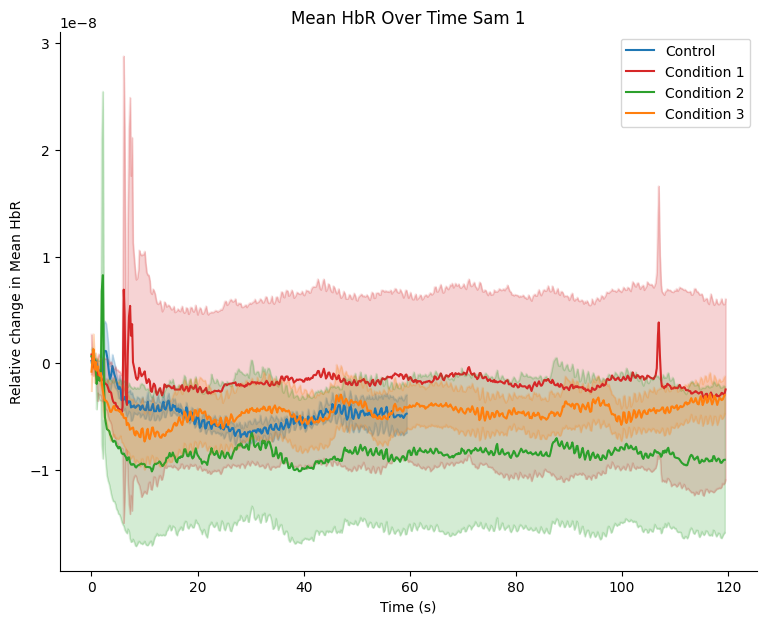

In [36]:
#Plot HbR

colors = ['blue','red','green','orange']
# Draw plot with error band and extra formatting to match seaborn style
fig, ax = plt.subplots(figsize=(9,7))
for i, hbr in enumerate(hbrs):
    # Matplotlib plot with custom error band

    # Define variables to plot
    y_mean = hbr['Mean']
    x = hbr['Time']

    # Compute upper and lower bounds using chosen uncertainty measure: here
    # it is a fraction of the standard deviation of measurements at each
    # time point based on the unbiased sample variance
    y_std = hbr['Stdev']
    error = 0.5*y_std
    lower = y_mean - error
    upper = y_mean + error

    ax.plot(x, y_mean, color=f'tab:{colors[i]}', label = f'{conditions[i]}')
    ax.plot(x, lower, color=f'tab:{colors[i]}', alpha=0.1)
    ax.plot(x, upper, color=f'tab:{colors[i]}', alpha=0.1)
    ax.fill_between(x, lower, upper, color=f'tab:{colors[i]}', alpha=0.2)
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Relative change in Mean HbR')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

plt.legend()
plt.title('Mean HbR Over Time Sam 1')



In [ ]:
# # This code was modified from the cell above to plot individual trials

# colors = ['blue','red','green','orange']
# # Draw plot with error band and extra formatting to match seaborn style
# fig, ax = plt.subplots(figsize=(9,7))
# for i, hbr in enumerate(hbrs):
#     # Matplotlib plot with custom error band

#     # Define variables to plot
#     y_mean = hbr['Trial 1']
#     x = hbr['Time']

#     # Compute upper and lower bounds using chosen uncertainty measure: here
#     # it is a fraction of the standard deviation of measurements at each
#     # time point based on the unbiased sample variance
#     y_std = hbr['Stdev']
#     error = 0.5*y_std
#     lower = y_mean - error
#     upper = y_mean + error

#     ax.plot(x, y_mean, color=f'tab:{colors[i]}', label = f'{conditions[i]}')
#     # ax.plot(x, lower, color=f'tab:{colors[i]}', alpha=0.1)
#     # ax.plot(x, upper, color=f'tab:{colors[i]}', alpha=0.1)
#     # ax.fill_between(x, lower, upper, color=f'tab:{colors[i]}', alpha=0.2)
#     ax.set_xlabel('Time (s)')
#     ax.set_ylabel('Relative change in Mean HbR')
#     ax.spines['top'].set_visible(False)
#     ax.spines['right'].set_visible(False)

# plt.legend()
# plt.title('Mean HbR Over Time Sam 1')



Text(0.5, 1.0, 'Mean HbO Over Time Niko 2')

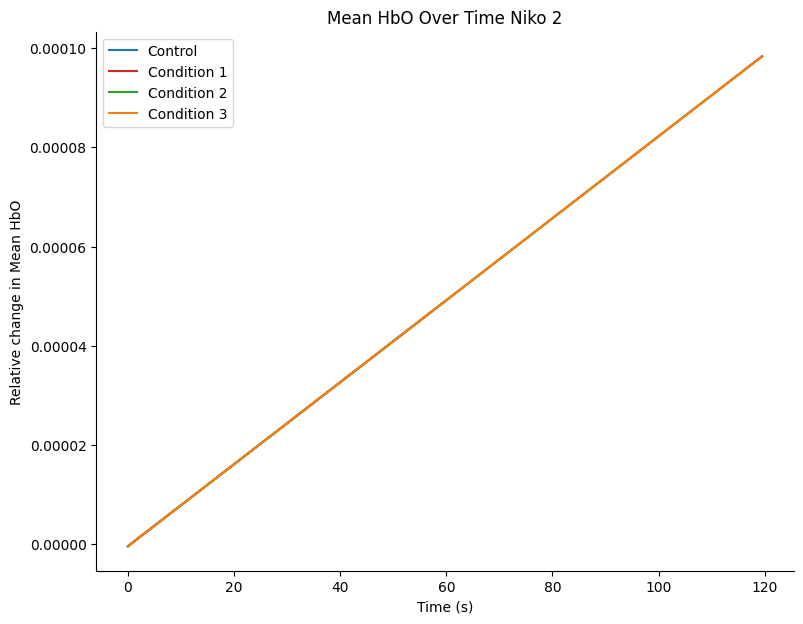

In [ ]:
# Plot HbO

colors = ['blue','red','green','orange']
# Draw plot with error band and extra formatting to match seaborn style
fig, ax = plt.subplots(figsize=(9,7))

for i, hbo in enumerate(hbos):
    # Matplotlib plot with custom error band

    # Define variables to plot
    y_mean = hbo['Mean']
    x = hbo['Time']

    # Compute upper and lower bounds using chosen uncertainty measure: here
    # it is a fraction of the standard deviation of measurements at each
    # time point based on the unbiased sample variance
    y_std = hbo['Stdev']
    error = 0.5*y_std
    lower = y_mean - error
    upper = y_mean + error

    ax.plot(x, y_mean, color=f'tab:{colors[i]}', label = f'{conditions[i]}')
    # ax.plot(x, lower, color=f'tab:{colors[i]}', alpha=0.1)
    # ax.plot(x, upper, color=f'tab:{colors[i]}', alpha=0.1)
    # ax.fill_between(x, lower, upper, color=f'tab:{colors[i]}', alpha=0.2)
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Relative change in Mean HbO')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

plt.legend()
plt.title('Mean HbO Over Time Niko 2')